# A Quick and Dirty Bayesian Election Model for 2022

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialise" data-toc-modified-id="Initialise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialise</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-python-modules" data-toc-modified-id="Import-necessary-python-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import necessary python modules</a></span></li><li><span><a href="#Locations" data-toc-modified-id="Locations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Locations</a></span></li><li><span><a href="#Plotting-setup" data-toc-modified-id="Plotting-setup-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting setup</a></span></li><li><span><a href="#PyMC-setup" data-toc-modified-id="PyMC-setup-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>PyMC setup</a></span></li><li><span><a href="#Useful-plotting-functions" data-toc-modified-id="Useful-plotting-functions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Useful plotting functions</a></span></li></ul></li><li><span><a href="#Get-the-data-we-will-use-for-analysis" data-toc-modified-id="Get-the-data-we-will-use-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data we will use for analysis</a></span><ul class="toc-item"><li><span><a href="#Voting-data" data-toc-modified-id="Voting-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Voting data</a></span></li><li><span><a href="#Seats-won-data" data-toc-modified-id="Seats-won-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Seats won data</a></span></li><li><span><a href="#Minor-seat-data" data-toc-modified-id="Minor-seat-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Minor seat data</a></span></li><li><span><a href="#Polling-History" data-toc-modified-id="Polling-History-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Polling History</a></span></li><li><span><a href="#Current-polling-data" data-toc-modified-id="Current-polling-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Current polling data</a></span></li></ul></li><li><span><a href="#Bayesian-model" data-toc-modified-id="Bayesian-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian model</a></span><ul class="toc-item"><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Model-constants" data-toc-modified-id="Model-constants-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model constants</a></span></li><li><span><a href="#Data-marshalling" data-toc-modified-id="Data-marshalling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Data marshalling</a></span></li><li><span><a href="#The-Model" data-toc-modified-id="The-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>The Model</a></span></li><li><span><a href="#Model-visualisation" data-toc-modified-id="Model-visualisation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Model visualisation</a></span></li><li><span><a href="#Sampling,-diagnostics,-data-extraction" data-toc-modified-id="Sampling,-diagnostics,-data-extraction-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Sampling, diagnostics, data extraction</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Plot results</a></span><ul class="toc-item"><li><span><a href="#2pp-Vote-Share" data-toc-modified-id="2pp-Vote-Share-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>2pp Vote Share</a></span></li><li><span><a href="#Seats-won-by-party" data-toc-modified-id="Seats-won-by-party-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Seats won by party</a></span></li><li><span><a href="#Parliamentary-outcomes" data-toc-modified-id="Parliamentary-outcomes-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Parliamentary outcomes</a></span></li></ul></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Initialise

### Import necessary python modules

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import statsmodels.api as sm

# system imports
from io import StringIO
from pathlib import Path

# local imports
import common

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed May 18 2022 11:24:28

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

matplotlib : 3.5.2
arviz      : 0.12.0
numpy      : 1.22.3
pandas     : 1.4.2
statsmodels: 0.13.2
pymc       : 4.0.0b6

Watermark: 2.3.0



### Locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting setup

In [4]:
plt.style.use('./markgraph.mplstyle')
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

### PyMC setup

In [5]:
az.style.use("arviz-darkgrid")

## Get the data we will use for analysis

### Voting data

In [6]:
historic_vote_data = """
Year    Date         ALP     LP      LNP  NP      CLP  DLP  DEM     GRN     ON   Others GovtBefore GovtAfter Labor2pp
1946    28-Sep-1946  49.7    33.0    -    10.7    -    -    -       -       -    6.6    Labor      Labor     54.1
1949    10-Dec-1949  46.0    39.3    -    10.8    -    -    -       -       -    3.9    Labor      Coalition 49.0
1951    28-Apr-1951  47.7    40.5    -    9.7     -    -    -       -       -    2.1    Coalition  Coalition 49.3
1954    29-May-1954  50.1    38.5    -    8.5     -    -    -       -       -    2.9    Coalition  Coalition 50.7
1955    10-Dec-1955  44.7    39.7    -    7.9     -    5.1  -       -       -    2.6    Coalition  Coalition 45.8
1958    22-Nov-1958  42.9    37.1    -    9.3     -    9.4  -       -       -    1.3    Coalition  Coalition 45.9
1961    09-Dec-1961  48.0    33.5    -    8.5     -    8.7  -       -       -    1.4    Coalition  Coalition 50.5
1963    30-Nov-1963  45.5    37.1    -    8.9     -    7.4  -       -       -    1.0    Coalition  Coalition 47.4
1966    26-Nov-1966  40.0    40.1    -    9.8     -    7.3  -       -       -    2.7    Coalition  Coalition 43.1
1969    25-Oct-1969  47.0    34.8    -    8.6     -    6.0  -       -       -    3.7    Coalition  Coalition 50.2
1972    02-Dec-1972  49.6    32.0    -    9.4     -    5.2  -       -       -    3.7    Coalition  Labor     52.7
1974    18-May-1974  49.3    34.9    -    10.8    -    1.4  -       -       -    3.5    Labor      Labor     51.7
1975    13-Dec-1975  42.8    41.8    -    11.0    0.2  1.3  -       -       -    2.8    Labor      Coalition 44.3
1977    10-Dec-1977  39.6    38.1    -    9.8     0.2  1.4  9.4     -       -    1.4    Coalition  Coalition 45.4
1980    18-Oct-1980  45.1    37.4    -    8.6     0.2  0.3  6.6     -       -    1.7    Coalition  Coalition 49.6
1983    05-Mar-1983  49.5    34.4    -    9.0     0.2  0.2  5.0     -       -    1.7    Coalition  Labor     53.2
1984    01-Dec-1984  47.5    34.1    -    10.6    0.3  0.6  5.4     -       -    1.4    Labor      Labor     51.8
1987    11-Jul-1987  45.8    34.3    -    11.5    0.2  -    6.0     -       -    2.0    Labor      Labor     50.8
1990    24-Mar-1990  39.4    34.8    -    8.4     0.3  -    11.3    1.4     -    4.4    Labor      Labor     49.9
1993    13-Mar-1993  44.9    36.8    -    7.2     0.3  -    3.8     1.9     -    5.2    Labor      Labor     51.4
1996    02-Mar-1996  38.8    38.7    -    8.2     0.4  -    6.8     2.9     -    4.3    Labor      Coalition 46.4
1998    03-Oct-1998  40.1    33.9    -    5.3     0.3  -    5.1     2.6     8.4  4.2    Coalition  Coalition 51.0
2001    10-Nov-2001  37.8    37.1    -    5.6     0.3  -    5.4     5.0     4.3  4.4    Coalition  Coalition 49.0
2004    09-Oct-2004  37.6    40.5    -    5.9     0.3  -    1.2     7.2     1.2  6.0    Coalition  Coalition 47.3
2007    24-Nov-2007  43.4    36.3    -    5.5     0.3  -    0.7     7.8     0.3  5.8    Coalition  Labor     52.7
2010    21-Aug-2010  38.0    30.5    9.1  3.7     0.3  -    0.2     11.8    0.2  6.2    Labor      Labor     50.1
2013    07-Sep-2013  33.4    32.0    8.9  4.3     0.3  0.3  -       8.6     0.2  11.9   Labor      Coalition 46.5
2016    02-Jul-2016  34.7    28.7    8.5  4.6     0.2  -    -       10.2    1.3  11.7   Coalition  Coalition 49.6
2019    18-May-2019  33.34   27.99   8.67 4.51    0.27 -    -       10.40   3.08 11.74  Coalition  Coalition 48.5
"""
# https://en.wikipedia.org/wiki/Two-party-preferred_vote
# https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp1617/FederalElectionResults

historic_vote_data = pd.read_csv(StringIO(historic_vote_data), 
                                 header=0, index_col=0, 
                                 skipinitialspace=True, sep=' ', 
                                 na_values='-',
                                 parse_dates=['Date'])
historic_vote_data['Coalition2pp'] = 100.0 - historic_vote_data['Labor2pp']
historic_vote_data['CoalitionMargin'] = historic_vote_data.Coalition2pp - historic_vote_data.Labor2pp
historic_vote_data


,Date,ALP,LP,LNP,NP,CLP,DLP,DEM,GRN,ON,Others,GovtBefore,GovtAfter,Labor2pp,Coalition2pp,CoalitionMargin
Year,,,,,,,,,,,,,,,,
1946,1946-09-28,49.70,33.00,NaN,10.70,NaN,NaN,NaN,NaN,NaN,6.60,Labor,Labor,54.1,45.9,-8.2
1949,1949-12-10,46.00,39.30,NaN,10.80,NaN,NaN,NaN,NaN,NaN,3.90,Labor,Coalition,49.0,51.0,2.0
1951,1951-04-28,47.70,40.50,NaN,9.70,NaN,NaN,NaN,NaN,NaN,2.10,Coalition,Coalition,49.3,50.7,1.4
1954,1954-05-29,50.10,38.50,NaN,8.50,NaN,NaN,NaN,NaN,NaN,2.90,Coalition,Coalition,50.7,49.3,-1.4
1955,1955-12-10,44.70,39.70,NaN,7.90,NaN,5.1,NaN,NaN,NaN,2.60,Coalition,Coalition,45.8,54.2,8.4
1958,1958-11-22,42.90,37.10,NaN,9.30,NaN,9.4,NaN,NaN,NaN,1.30,Coalition,Coalition,45.9,54.1,8.2
1961,1961-12-09,48.00,33.50,NaN,8.50,NaN,8.7,NaN,NaN,NaN,1.40,Coalition,Coalition,50.5,49.5,-1.0
1963,1963-11-30,45.50,37.10,NaN,8.90,NaN,7.4,NaN,NaN,NaN,1.00,Coalition,Coalition,47.4,52.6,5.2
1966,1966-11-26,40.00,40.10,NaN,9.80,NaN,7.3,NaN,NaN,NaN,2.70,Coalition,Coalition,43.1,56.9,13.8


In [7]:
OTHERS = ['DLP', 'DEM', 'GRN', 'ON', 'Others']
other_vote_summary = historic_vote_data[OTHERS].fillna(0).sum(axis=1)
other_vote_summary

Year
1946     6.60
1949     3.90
1951     2.10
1954     2.90
1955     7.70
1958    10.70
1961    10.10
1963     8.40
1966    10.00
1969     9.70
1972     8.90
1974     4.90
1975     4.10
1977    12.20
1980     8.60
1983     6.90
1984     7.40
1987     8.00
1990    17.10
1993    10.90
1996    14.00
1998    20.30
2001    19.10
2004    15.60
2007    14.60
2010    18.40
2013    21.00
2016    23.20
2019    25.22
dtype: float64

### Seats won data

In [8]:
seats_won = pd.read_csv(f'{PRIVATE_DATA_DIR}Seat History.csv',
                        header=[0,1], index_col=0, 
                       )
seats_won = seats_won['Seats']
seats_won.index = [pd.Timestamp(x) for x in seats_won.index]
seats_won

,ALP,L+NP,Oth.,Total
1919-12-13,25.0,38.0,2.0,75.0
1922-12-16,29.0,40.0,6.0,75.0
1925-11-14,23.0,50.0,2.0,75.0
1928-11-17,31.0,42.0,2.0,75.0
1929-10-12,46.0,24.0,5.0,75.0
1931-12-19,14.0,50.0,11.0,75.0
1934-09-15,18.0,42.0,14.0,74.0
1937-10-23,29.0,43.0,2.0,74.0
1940-09-21,32.0,36.0,6.0,74.0
1943-08-21,49.0,19.0,6.0,74.0


### Minor seat data

In [9]:
minors = """Yeer; Minor seats; Coalition minor; Notes
2019; 6; 4;    4 in Coalition seats: Katter, Haines, Steggal, Sharkie - 2 in Labor Seats: Wilkie, Bandt
2016; 5; 3;    3 in Coalition seats: Katter, McGowan, Sharkie - 2 in Labor Seats: Wilkie, Bandt
2013; 5; 3;    3 in Coalition seats: Palmer, McGowan, Katter - 2 in Labor seats: Bandt, Wilkie
2010; 6; 4;    4 in Coalition seats: Oakshott, Windsor, Katter, Crook - 2 in Labor seats: Bandt, Wilkie
2007; 2; 2;    2 in Coalition seats: Windsor, Katter
2004; 3; 3;    3 in Coalition seats: Andren, Windsor, Katter
2001; 3; 3;    3 in Coalition Seats: Andren, Windsor, Katter
1998; 1; 1;    1 in a Coalition seat: Andren
1996; 5; 4;    4 in Coalition seats: Hanson, Andren, Rocher, Filing, - 1 in a Labor seat: Campbell
1993; 2; 1;    1 in Coalition a seat: Mack - 1 in a Labor seat: Cleary
1990; 1; 1;    1 in a Coalition seat Mack
1987; 0; 0;
1984; 0; 0;
1983; 0; 0; """


minors = pd.read_csv(StringIO(minors), header=0, index_col=0, 
                    skipinitialspace=True, sep=';')
minors['Coalition Proportion'] = minors['Coalition minor'] / minors['Minor seats']
minors['Date'] = historic_vote_data['Date']
minors

,Minor seats,Coalition minor,Notes,Coalition Proportion,Date
Yeer,,,,,
2019,6,4,"4 in Coalition seats: Katter, Haines, Steggal,...",0.666667,2019-05-18
2016,5,3,"3 in Coalition seats: Katter, McGowan, Sharkie...",0.600000,2016-07-02
2013,5,3,"3 in Coalition seats: Palmer, McGowan, Katter ...",0.600000,2013-09-07
2010,6,4,"4 in Coalition seats: Oakshott, Windsor, Katte...",0.666667,2010-08-21
2007,2,2,"2 in Coalition seats: Windsor, Katter",1.000000,2007-11-24
2004,3,3,"3 in Coalition seats: Andren, Windsor, Katter",1.000000,2004-10-09
2001,3,3,"3 in Coalition Seats: Andren, Windsor, Katter",1.000000,2001-11-10
1998,1,1,1 in a Coalition seat: Andren,1.000000,1998-10-03
1996,5,4,"4 in Coalition seats: Hanson, Andren, Rocher, ...",0.800000,1996-03-02


In [10]:
adjusted_seats = seats_won.copy()
adjusted_seats.index = adjusted_seats.index.year
adjusted_seats = adjusted_seats.loc[minors.index]
adjusted_seats['Coalition adjusted'] = adjusted_seats['L+NP'] + minors['Coalition minor']
adjusted_seats['Labor adjusted'] = adjusted_seats['ALP'] + minors['Minor seats'] - minors['Coalition minor']
adjusted_seats['Coalition proportion'] = adjusted_seats['Coalition adjusted'] / adjusted_seats.Total
adjusted_seats['Labor proportion'] = adjusted_seats['Labor adjusted'] / adjusted_seats.Total
adjusted_seats['CoalitionMargin'] = adjusted_seats['Coalition proportion'] - adjusted_seats['Labor proportion']

assert (adjusted_seats['Labor adjusted'] + adjusted_seats['Coalition adjusted'] == adjusted_seats.Total).all()


### Polling History

In [11]:
# Historical polling data from Ethan at https://armariuminterreta.com/
IGNORE_BEFORE = pd.Timestamp('1983-01-01')

historical = pd.read_excel(f'{PRIVATE_DATA_DIR}Australian Federal Polling Database.xlsx',)
historical = historical[historical.StartDate >= IGNORE_BEFORE]
len(historical)

2853

In [12]:
historical.columns

Index(['StartDate', 'EndDate', 'ElectionYear', 'FieldDays', 'DaysToElection',
       'DaysFromLastElection', 'Incumbent', 'Pollster', 'SamplingMethod',
       'SampleSize', 'ALP', 'LNC', 'Liberals', 'Nationals', 'DLP', 'Democrats',
       'Greens', 'PHON', 'Others', 'Undecided', 'Published2pp', 'RespAlloc2pp',
       'Raw2pp', 'Est2pp', '2pp', 'RoundedEst2pp', 'PrimMargin', 'Result2pp',
       'DevALP', 'DevLNC', 'DevLib', 'DevNat', 'DevDLP', 'DevDem', 'DevGrn',
       'DevPHON', 'DevOth', 'DevPub2pp', 'DevEst2pp', 'Dev2pp',
       'DevPastInc2pp', 'DevInc2pp', 'AbsDevALP', 'AbsDevLNC', 'AbsDevLib',
       'AbsDevNat', 'AbsDevDLP', 'AbsDevDem', 'AbsDevGrn', 'AbsDevPHON',
       'AbsDevOth', 'AbsDevPub2pp', 'AbsDevEst2pp', 'AbsDev2pp'],
      dtype='object')

In [13]:
# polling summary
FINAL_PERIOD = 14 # days
COALITION_2PP = 'Est2pp'
MAJORS = ['ALP', 'LNC', 'Liberals', 'Nationals', ]
MINORS = ['DLP', 'Democrats', 'Greens', 'PHON', 'Others', ]
PRIMARY = MAJORS + MINORS

summary_tpp = {}
summary_other = {}
for date in historic_vote_data['Date']:
    end = pd.Timestamp(date)
    begin = end - pd.Timedelta(days=FINAL_PERIOD)
    data = historical[(historical['StartDate'] >= begin) & (historical['EndDate'] <= end)].fillna(0)
    if len(data) < 1:
        continue
        
    # tpp poll estimate
    summary_tpp[date] = data[COALITION_2PP].mean()
    
    # "Other" poll estimate
    summary_other[date] =( data[MINORS].sum(axis=1) / data[PRIMARY].sum(axis=1) * 100).mean()
    
tpp_poll_summary = pd.Series(summary_tpp)
tpp_poll_summary

1983-03-05    45.500000
1984-12-01    44.800000
1987-07-11    46.760000
1990-03-24    48.633333
1993-03-13    50.262500
1996-03-02    51.622222
1998-10-03    48.914286
2001-11-10    50.840000
2004-10-09    52.122222
2007-11-24    45.910000
2010-08-21    47.641667
2013-09-07    53.253333
2016-07-02    50.288889
2019-05-18    48.385714
dtype: float64

In [14]:
# Other polling summary
other_poll_summary = pd.Series(summary_other)
other_poll_summary

1983-03-05     6.500000
1984-12-01     9.000000
1987-07-11     6.926094
1990-03-24    15.663467
1993-03-13     9.631828
1996-03-02    14.388889
1998-10-03    15.318168
2001-11-10    12.307635
2004-10-09    12.083313
2007-11-24    10.131941
2010-08-21    16.294466
2013-09-07    20.767984
2016-07-02    23.212011
2019-05-18    25.685714
dtype: float64

### Current polling data

In [15]:
current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' # f'{DATA_DIR}two_party_preferred.csv'
common.check_file_current(current_polls, 
    'Make sure you run the data capture notebook first')

tpp = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
final = tpp['Mean Date'].max()
start = final - pd.Timedelta(days=FINAL_PERIOD)
current_tpp_poll = tpp.loc[
    (tpp['Mean Date'] >= start) & (tpp['Mean Date'] <= final),
    'Calculated 2pp L/NP'].mean()
current_tpp_poll

46.37809097891357

In [16]:
OTHERS = ['Primary vote GRN', 'Primary vote OTH', 'Primary vote UAP', 'Primary vote ONP', ]
current_primary_others_poll = tpp.loc[
    (tpp['Mean Date'] >= start) & (tpp['Mean Date'] <= final),
    OTHERS].sum(axis=1, skipna=True).mean()
current_primary_others_poll

29.240306288693386

## Bayesian model

### Supporting functions

In [17]:
def annotate_dots(ax, x, y, s):
    # annotate scatter plot dots
    for x_, y_, s_ in zip(x, y, [f'{t}' for t in s]):
        ax.text(x_, y_, s_, ha='left', va='bottom')

In [18]:
def regression_line(ax, x, y):
    # place a regression line of the plot
    m, b = np.polyfit(x, y, 1)
    regression_text = f'y = {m:0.3f}x {"+ " if b >=0 else ""}{b:0.3f}'
    x_r = np.array(sorted(x))
    y_r = (m * x_r) + b
    ax.plot(x_r, y_r, lw=1, c="#dd0000", label=regression_text)
    return regression_text

In [19]:
def y_eq_x_line(ax):
    # place an y=x line on the plot ...
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]), 
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, lw=1, ls='--', c='darkorchid', label='y = x')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

In [20]:
def get_var_as_series(inferencedata, variable_name):
    """Return a series - index are draws"""
    return pd.Series(
        inferencedata
        .posterior
        .stack(draws=("chain", "draw"))[variable_name]
        .values
    )

### Model constants

In [21]:
CUT_OFF = 1983
FIFTY = 50.0 # percent - offset for centre adjustment
SEATS_IN_HOUSE = 151

### Data marshalling

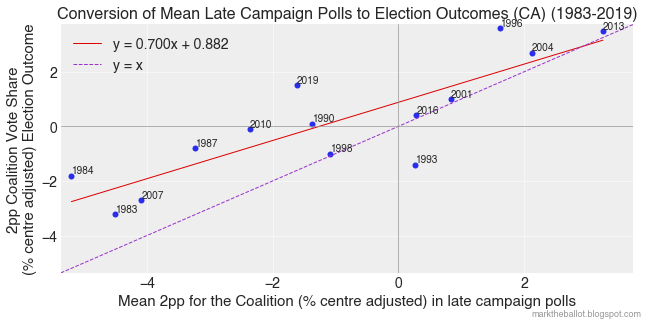

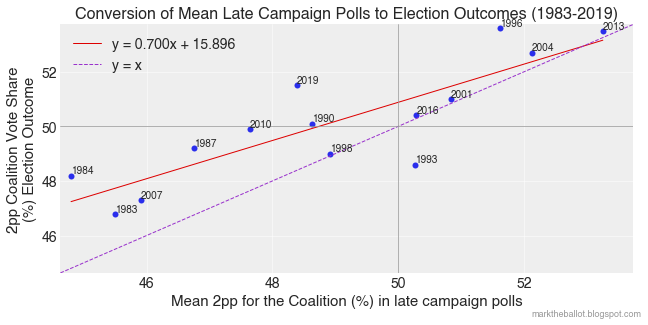

In [22]:
# polls and votes in whole percentage points - centre adjusted
# we sort to ensure our lists are in the same order
# We use a centre-adjusted transformation to make the NUTS sampler work better

polls = tpp_poll_summary.sort_index().values - FIFTY
votes = (
    historic_vote_data.loc[historic_vote_data.index >= CUT_OFF, 'Coalition2pp']
    .sort_index()
    .values - FIFTY
)
assert len(polls) == len(votes) # to be sure ...

fig, ax = common.initiate_plot()
ax.scatter(polls, votes)
annotate_dots(ax, polls, votes, tpp_poll_summary.sort_index().index.year)
regression_line(ax, polls, votes, )
y_eq_x_line(ax)
ax.axvline(0, lw=0.75, c='#999999')
ax.axhline(0, lw=0.75, c='#999999')
ax.legend(loc='best')
common.plot_finalise(ax,
    title='Conversion of Mean Late Campaign Polls to Election Outcomes (CA) '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Mean 2pp for the Coalition (% centre adjusted) in late campaign polls',
                     ylabel='2pp Coalition Vote Share\n(% centre adjusted) Election Outcome')

# And the same chart withou cenre-adjustment
x, y = polls + FIFTY, votes + FIFTY
fig, ax = common.initiate_plot()
ax.scatter(x, y)
annotate_dots(ax, x, y, tpp_poll_summary.sort_index().index.year)
regression_line(ax, x, y, )
y_eq_x_line(ax)
ax.axvline(FIFTY, lw=0.75, c='#999999')
ax.axhline(FIFTY, lw=0.75, c='#999999')
ax.legend(loc='best')
common.plot_finalise(ax,
    title='Conversion of Mean Late Campaign Polls to Election Outcomes '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Mean 2pp for the Coalition (%) in late campaign polls',
                     ylabel='2pp Coalition Vote Share\n(%) Election Outcome')



__Note:__ The solid red regression line suggests the polls perform poorer when Labor is doing well in the polls, 
but they are more accurate when the Coalition is doing well. This is highlighted by the dashed y=x line. 

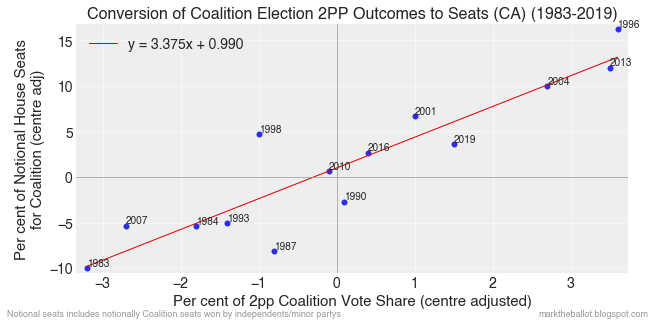

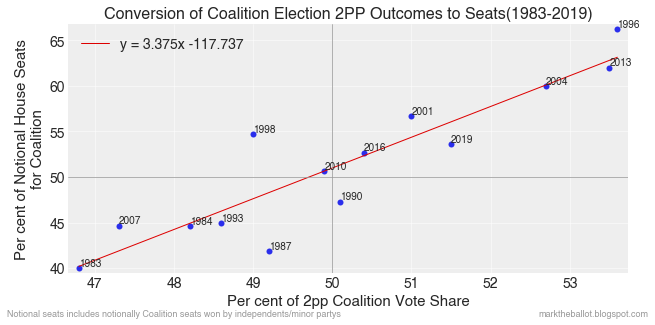

In [23]:
# metric is percent - centre-adjusted 
# data
c_seats = (adjusted_seats['Coalition proportion'].sort_index().values * 100) - FIFTY
c_votes = (
    historic_vote_data.loc[adjusted_seats.index, 'Coalition2pp'] 
    .sort_index()
    .values
) - FIFTY
assert len(c_seats) == len(c_votes)

# chart
fig, ax = common.initiate_plot()
ax.scatter(c_votes, c_seats)
annotate_dots(ax, c_votes, c_seats, adjusted_seats.sort_index().index)
regression_line(ax, c_votes, c_seats, )
ax.axvline(0, lw=0.75, c='#999999')
ax.axhline(0, lw=0.75, c='#999999')
ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Conversion of Coalition Election 2PP Outcomes to Seats (CA) '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Per cent of 2pp Coalition Vote Share (centre adjusted)',
                     ylabel='Per cent of Notional House Seats\nfor Coalition (centre adj)',
                     lfooter='Notional seats includes notionally Coalition seats won '
                            'by independents/minor partys')

# once more for punters
x, y = c_votes + FIFTY, c_seats + FIFTY
fig, ax = common.initiate_plot()
ax.scatter(x, y)
annotate_dots(ax, x, y, adjusted_seats.sort_index().index)
regression_line(ax, x, y, )
ax.axvline(FIFTY, lw=0.75, c='#999999')
ax.axhline(FIFTY, lw=0.75, c='#999999')
ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Conversion of Coalition Election 2PP Outcomes to Seats'
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Per cent of 2pp Coalition Vote Share',
                     ylabel='Per cent of Notional House Seats\nfor Coalition',
                     lfooter='Notional seats includes notionally Coalition seats won '
                            'by independents/minor partys')


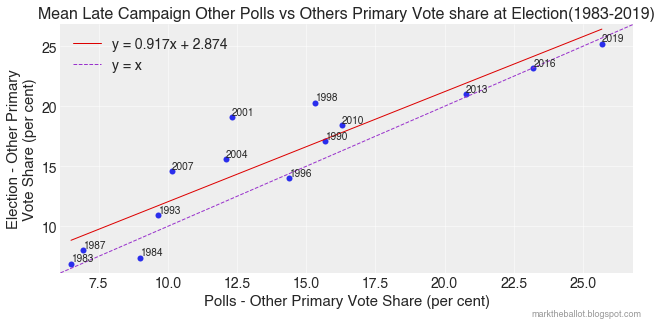

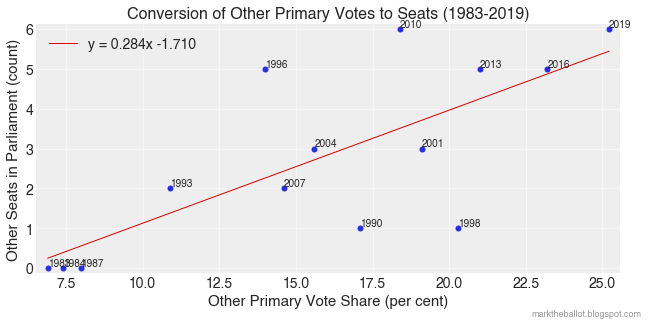

In [24]:
OTHER_CUT_OFF = pd.Timestamp('1983-01-01') 
other_polls = other_poll_summary[other_poll_summary.index >= OTHER_CUT_OFF].sort_index().values
other_seats = minors.loc[minors.index >= OTHER_CUT_OFF.year, 'Minor seats'].astype(float).sort_index().values
other_votes = other_vote_summary[other_vote_summary.index >= OTHER_CUT_OFF.year].sort_index().values
assert len(other_polls) == len(other_seats) == len(other_votes)

fig, ax = common.initiate_plot()
ax.scatter(other_polls, other_votes)
annotate_dots(ax, other_polls, other_votes, adjusted_seats.sort_index().index)
regression_line(ax, other_polls, other_votes, )
y_eq_x_line(ax)
ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Mean Late Campaign Other Polls vs Others Primary Vote share at Election'
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Polls - Other Primary Vote Share (per cent)',
                     ylabel='Election - Other Primary\nVote Share (per cent)',)

fig, ax = common.initiate_plot()
ax.scatter(other_votes, other_seats)
annotate_dots(ax, other_votes, other_seats, adjusted_seats.sort_index().index)
regression_line(ax, other_votes, other_seats, )

ax.legend(loc='upper left')
common.plot_finalise(ax,
    title='Conversion of Other Primary Votes to Seats '
          f'({tpp_poll_summary.index.year.min()}-{tpp_poll_summary.index.year.max()})',
                     xlabel='Other Primary Vote Share (per cent)',
                     ylabel='Other Seats in Parliament (count)',)


Observation: for the last three elections, the polls did a pretty good job at forecasting the other vote share.

Nonetheless, the primary vote share is only a weak indicator of the number of "other: seats that are won.

### The Model

In [25]:
with pm.Model() as the_model:
    
    # --- POLLS to ELECTION OUTCOME 
    # This is a StudentT based linear regression
    pe_x_coeff = pm.Normal('pe_x_coeff', 0, sigma=10)
    pe_intercept = pm.Normal('pe_intercept', 0, sigma=10)
    pe_nu = pm.Gamma('pe_nu', alpha=5, beta=0.1) 
    pe_sigma = pm.Exponential('pe_sigma', lam=2.0)
    historic_polls_to_votes = pm.StudentT("historic_polls_to_votes", 
                                nu=pe_nu, # For StudentT
                                mu=pe_intercept + polls * pe_x_coeff, 
                                sigma=pe_sigma,
                                observed=votes,)
    # - projected election 2pp result
    vote_2pp_C_predicted_ca = pm.StudentT("vote_2pp_C_predicted_ca", 
                                nu=pe_nu, # For StudentT
                                mu=(current_tpp_poll - FIFTY) * pe_x_coeff + pe_intercept,
                                sigma=pe_sigma,)
    vote_2pp_C_predicted = pm.Deterministic('vote_2pp_C_predicted',
                                          FIFTY + vote_2pp_C_predicted_ca)
    vote_2pp_L_predicted = pm.Deterministic('vote_2pp_L_predicted',
                                          100.0 - vote_2pp_C_predicted)
    
    # - ELECTION (2PP) OUTCOME to SEATS IN PARLIAMENT
    # (before the minor parties get a bite at those seats).
    # This is a linear model
    es_slope = pm.Normal('es_slope', mu=1, sigma=10)
    es_intercept = pm.Normal('es_intercept', mu=0, sigma=10)
    es_error = pm.Exponential('es_error', lam=2.0)
    es_nu = pm.Gamma('es_nu', alpha=5, beta=0.1) 
    historic_votes_to_seats = pm.StudentT('historic_votes_to_seats',
                                          nu=es_nu,
                                          mu=c_votes*es_slope+es_intercept,
                                          sigma=es_error,
                                          observed=c_seats,)
    seats_C_percent_notional_projected = pm.StudentT('seats_C_percent_notional_projected',
                                          nu=es_nu,
                                          mu=(vote_2pp_C_predicted-50.0)*es_slope+es_intercept, 
                                          sigma=es_error,)
    
    seats_C_count_notional_projected = pm.Deterministic('seats_C_count_notional_projected',
                                          SEATS_IN_HOUSE * ((seats_C_percent_notional_projected+50) / 100))
    seats_L_count_notional_projected = pm.Deterministic('seats_L_count_notional_projected',
                                          SEATS_IN_HOUSE - seats_C_count_notional_projected)

    # --- OTHER PARTY VOTES to OTHER PARTY SEATS
    # historic other parties seats from votes (as a proxy for polling). 
    # Another regression
    # BIG ASSUMPTION HERE: polls over the past three election 
    # have been pretty spot-on for getting the other vote share
    op_slope = pm.Normal('op_slope', mu=1, sigma=10) 
    op_intercept = pm.Normal('op_intercept', mu=0, sigma=10)
    op_error = pm.Exponential('op_error', lam=0.5) # less constrained 
    op_nu = pm.Gamma('op_nu', 5, beta=0.5) # less constrained because not great fit
    historic_others_votes_to_seats = pm.StudentT('historic_others_votes_to_seats',
                                          nu=op_nu,
                                          mu=other_votes*op_slope+op_intercept,
                                          sigma=op_error,
                                          observed=other_seats,)
    # predict the number of the other seats 
    seats_other_count = pm.StudentT('seats_other_count', nu=op_nu,
                                    mu=current_primary_others_poll*op_slope+op_intercept,
                                    sigma=op_error,)
    # this is the least defensible element of this model
    coalition_proportion_of_other = pm.Uniform('coalition_proportion_of_other', 
                                               lower=0.65, upper=0.75)

    # --- TABULATE FINAL RESULTS
    coalition_lost_to_other = pm.Deterministic('coalition_lost_to_other', 
                                               coalition_proportion_of_other 
                                               * seats_other_count)
    
    final_coalition_seats = pm.Deterministic('final_coalition_seats',
                                             seats_C_count_notional_projected 
                                             - coalition_lost_to_other)
    
    final_labor_seats = pm.Deterministic('final_labor_seats',
                                         SEATS_IN_HOUSE - final_coalition_seats 
                                         - seats_other_count)

### Model visualisation

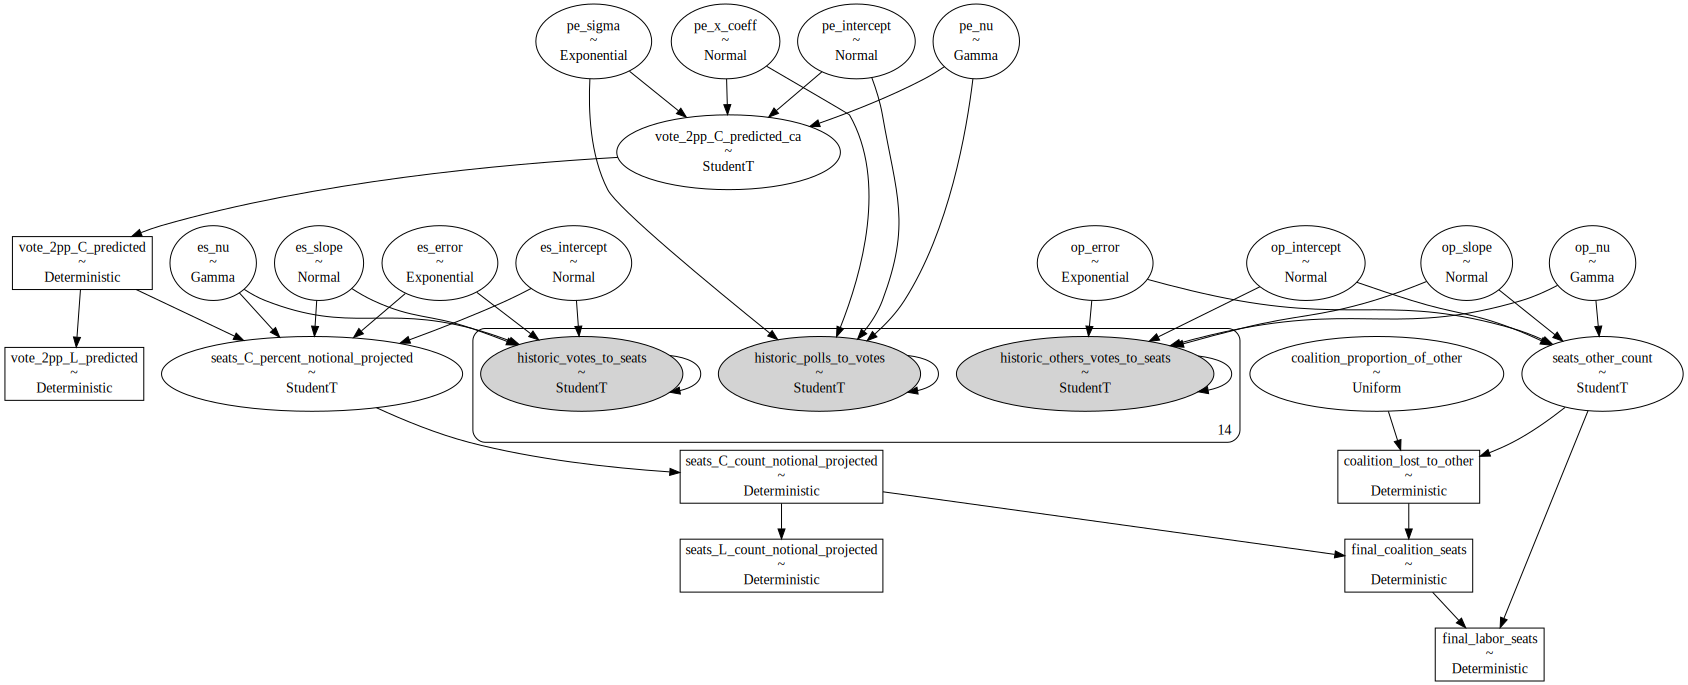

In [26]:
gv = pm.model_to_graphviz(the_model)
gv.render(format='png', filename='model-graphviz')
display(gv)

### Sampling, diagnostics, data extraction

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [pe_x_coeff, pe_intercept, pe_nu, pe_sigma, vote_2pp_C_predicted_ca, es_slope, es_intercept, es_error, es_nu, seats_C_percent_notional_projected, op_slope, op_intercept, op_error, op_nu, seats_other_count, coalition_proportion_of_other]


Sampling 10 chains for 10_000 tune and 50_000 draw iterations (100_000 + 500_000 draws total) took 176 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pe_x_coeff,0.701,0.128,0.461,0.944,0.000,0.000,334324.0,281875.0,1.0
pe_intercept,0.891,0.351,0.231,1.562,0.001,0.000,317103.0,268147.0,1.0
vote_2pp_C_predicted_ca,-1.649,1.297,-4.110,0.813,0.003,0.002,262567.0,223135.0,1.0
es_slope,3.376,0.380,2.646,4.085,0.001,0.000,353064.0,267818.0,1.0
es_intercept,0.966,0.800,-0.535,2.494,0.001,0.001,352449.0,271651.0,1.0
seats_C_percent_notional_projected,-4.596,5.426,-14.771,5.768,0.010,0.008,271081.0,254964.0,1.0
op_slope,0.293,0.074,0.149,0.431,0.000,0.000,293488.0,283359.0,1.0
op_intercept,-1.838,1.234,-4.177,0.524,0.002,0.002,305390.0,289718.0,1.0
seats_other_count,6.717,2.119,2.632,10.662,0.004,0.003,370096.0,301569.0,1.0
pe_nu,49.798,22.321,12.269,90.817,0.035,0.025,378834.0,244965.0,1.0


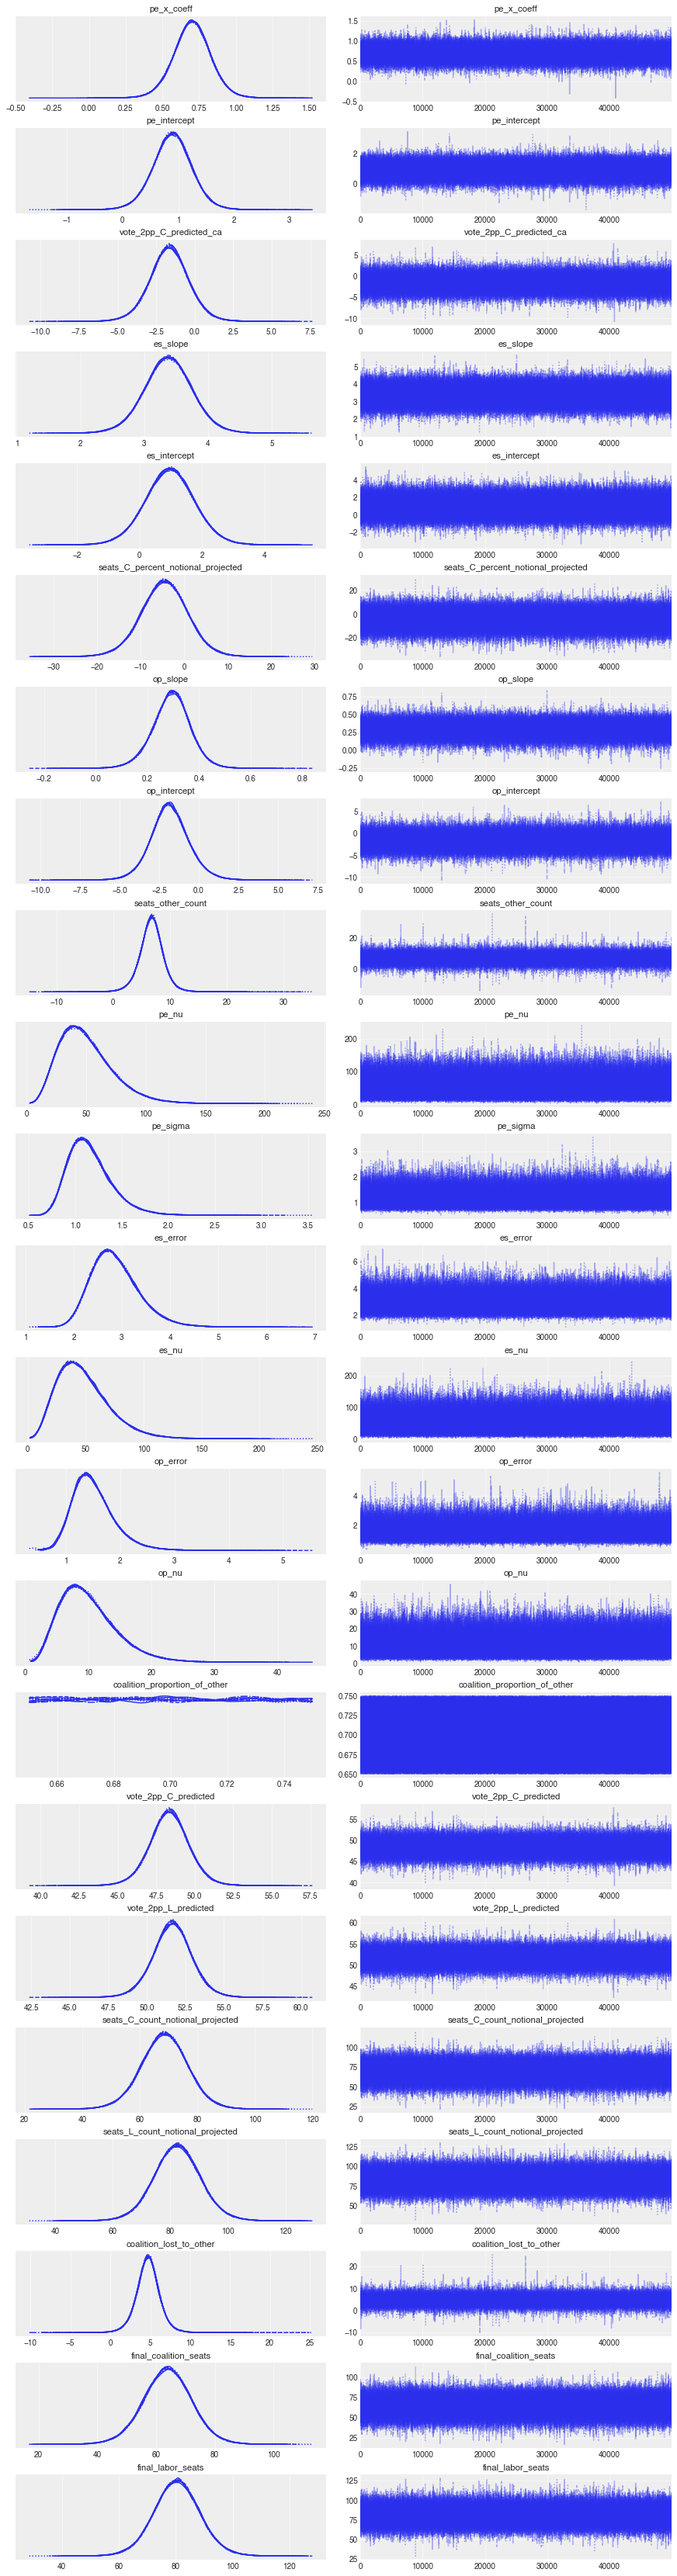

In [27]:
CHAINS = 10 # take advantage of my multi-core machine
SAMPLES_PER_CHAIN = 50_000
TUNE_PER_CHAIN = 10_000

with the_model:
    # --- sampling
    trace = pm.sample(return_inferencedata=True, 
                      draws=SAMPLES_PER_CHAIN, tune=TUNE_PER_CHAIN, 
                      chains=CHAINS, cores=CHAINS, )
    
    # --- diagnostics
    summary = az.summary(trace) 
    az.rcParams["plot.max_subplots"] = 100
    az.plot_trace(trace)
    
summary

### Plot results

#### 2pp Vote Share

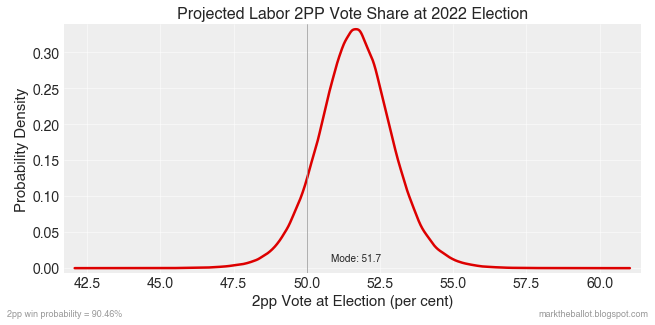

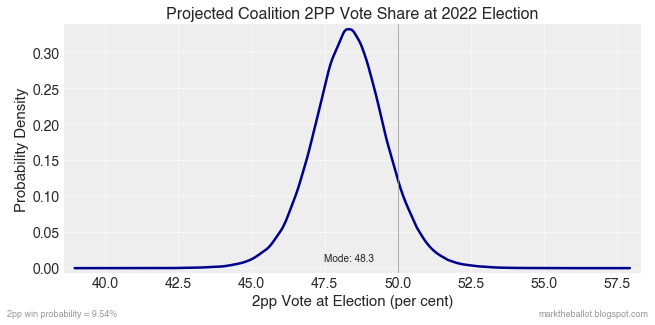

In [28]:
# Projected 2pp Vote at Election
plotables = {
    'Projected Labor 2PP Vote Share at 2022 Election': ['vote_2pp_L_predicted', COLOR_LABOR],
    'Projected Coalition 2PP Vote Share at 2022 Election': ['vote_2pp_C_predicted', COLOR_COALITION]
}

for heading, (data_item, color) in plotables.items():
    tpp_projected = get_var_as_series(trace, data_item)
    kde = sm.nonparametric.KDEUnivariate(tpp_projected)
    fit = kde.fit(fft=True)
    series = pd.Series(fit.density, index=fit.support)
    mode = series.idxmax()
    win_probability = series[series.index > 50].sum() / series.sum() * 100
   
    fig, ax = common.initiate_plot()
    ax.plot(series, c=color, lw=2.5)
    ax.axvline(50, lw=0.75, c='#999999')
    ax.text(mode, 0.01, f'Mode: {mode:0.1f}', ha='center')
    
    common.plot_finalise(ax, title=heading, 
                         xlabel='2pp Vote at Election (per cent)', 
                         ylabel='Probability Density',
                         lfooter=f'2pp win probability = {win_probability:0.2f}%',
                        )

#### Seats won by party

In [29]:
# We will reject samples with less than 0 other seats
# This is a kludge - born of necessity - because we don't have a compelling other parties model
others = get_var_as_series(trace, 'seats_other_count')
keep_mask = others > 0
print(f'Number of samples rejected: {(~keep_mask).sum()}')
print(f'Number of samples kept: {keep_mask.sum()}')

Number of samples rejected: 1889
Number of samples kept: 498111


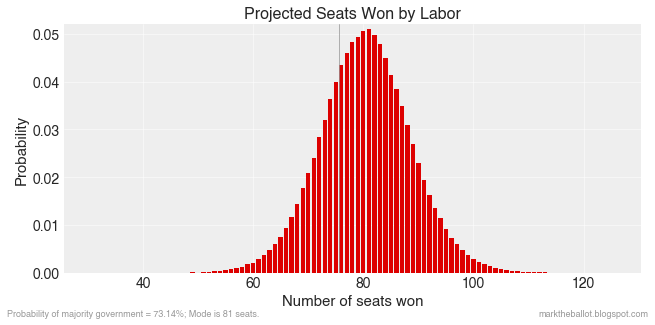

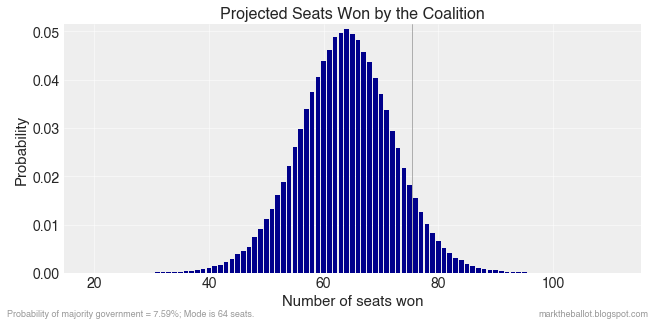

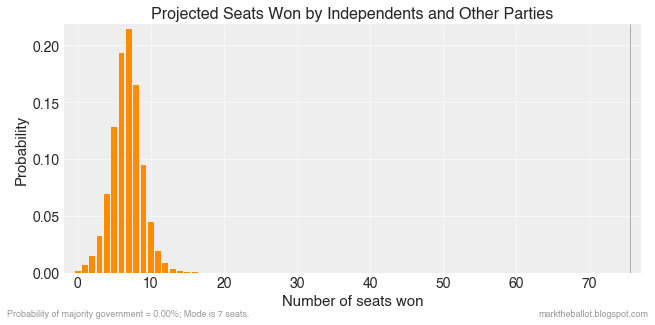

In [30]:
plotable = {
    'Projected Seats Won by Labor': ['final_labor_seats', COLOR_LABOR],
    'Projected Seats Won by the Coalition': ['final_coalition_seats', COLOR_COALITION],
    'Projected Seats Won by Independents and Other Parties': ['seats_other_count',
                                                              COLOR_OTHER],
}

majority = SEATS_IN_HOUSE/2.0
for title, (data_item, color) in plotable.items():
    seats = get_var_as_series(trace, data_item)[keep_mask]
    binned = seats.round(0).value_counts().sort_index()
    normalised = binned / binned.sum()
    probability = normalised[normalised.index > majority].sum() * 100
    mode = int(normalised.idxmax())
    
    fig, ax = common.initiate_plot()
    ax.bar(normalised.index, normalised, color=color)

    ax.axvline(majority, lw=0.75, c='#999999')
    
    common.plot_finalise(ax, title=title, 
                         xlabel='Number of seats won', 
                         ylabel='Probability',
                         lfooter='Probability of majority government = '
                                 f'{probability:0.2f}%; '
                                 f'Mode is {mode} seats.',
                        )

#### Parliamentary outcomes

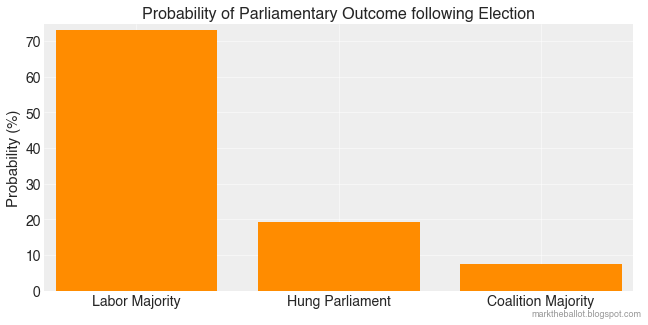

In [31]:
getable = {
    'Labor Majority': 'final_labor_seats',
    'Coalition Majority': 'final_coalition_seats',
}

results = {}
for label, data_item in getable.items():
    seats = get_var_as_series(trace, data_item)[keep_mask]
    results[label] =  (seats > majority).sum() / seats.count()
results['Hung Parliament'] = 1.0 - results['Labor Majority'] - results['Coalition Majority']
results = (pd.Series(results) * 100).sort_values(ascending=False) # per cent

fig, ax = common.initiate_plot()
ax.bar(results.index, results, color=color)

common.plot_finalise(ax, title='Probability of Parliamentary Outcome following Election', 
                         xlabel=None, 
                         ylabel='Probability (%)',
                        )

In [32]:
results

Labor Majority        73.140926
Hung Parliament       19.268195
Coalition Majority     7.590878
dtype: float64

## The End

In [33]:
print('Done')

Done
